In [16]:
### ### ### IMPORTS ### ### ### 
import os
from fredapi import Fred # https://github.com/mortada/fredapi
import pandas as pd
import timeit
from datetime import datetime, date
import time
import scipy.stats as stats
from scipy.stats import gmean
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
date = date.today()

In [17]:
### ### ### API AUTHENTICATION USING ENVIRONMENTAL VARIABLES ### ### ### 
FRED_API = os.environ['FRED_API']
api = Fred(api_key=FRED_API)

In [18]:
### ### ### LOG TIME SCRIPT BEGINS ### ### ### 
start = datetime.now()
print('*****   *****   SCRIPT STARTING   *****   *****')
print('SCRIPT STARTED AT: ',start)

*****   *****   SCRIPT STARTING   *****   *****
SCRIPT STARTED AT:  2023-01-11 11:16:34.806690


In [116]:
### ### ### GRAB FRED DATA SERIES ### ### ### 
# The API will return a series, but we define it as one anyway so we can pass a name to be used in df concatenation afterward

# Inputs for Tobin's Q / VM Index
net_worth = pd.Series(api.get_series('TNWMVBSNNCB'),name='net_worth') # nonfinancial networth
market_cap = pd.Series(api.get_series('WILL5000PRFC'),name='market_cap') # wilshire 5000 price cap
corp_debt_pct = pd.Series(api.get_series('NCBCMDPMVCE'),name='corp_debt_pct') # nonfinancial corporate debt % of market value of corp equities

time.sleep(3)
# Inputs for net liquidity measure
frb_total_assets = pd.Series(api.get_series('WALCL'),name='frb_ta') # asset side of FRB balance sheet
on_rrp = pd.Series(api.get_series('RRPONTSYD'),name='on_rrp') # overnight reverse repo notional
trsy_general_account = pd.Series(api.get_series('WTREGEN'),name='tsy_ga') # treasury general account
corp_profits = pd.Series(api.get_series('CP'),name='corp_profits') #corp profits without inventory value or capital consumption adjustments
corp_profits_adj = pd.Series(api.get_series('CPATAX'),name='corp_profits_adj') #corp profits with inventory value or capital consumption adjustments
#trsy_debt = pd.Series(api.get_series('MVMTD027MNFNBDAL'),name='tsy_debt_mktv') #market value of marketable treasury debt
time.sleep(3)
# Inputs for yield curve

sofr = pd.Series(api.get_series('SOFR'),name='SOFR') # Secured Overnight Funding Rate
sofr_v = pd.Series(api.get_series('SOFRVOL'),name='SOFR_V') # Secured Overnight Funding Rate
effr = pd.Series(api.get_series('EFFR'),name='EFFR') # Effective Federal Funds Rate
effr_v = pd.Series(api.get_series('EFFRVOL'),name='EFFR_V') # Effective Federal Funds Rate
tffr_ul = pd.Series(api.get_series('DFEDTARU'),name='TFRR_UL') # Target Fed Funds Rate, Upper Limit
tfrr_ll = pd.Series(api.get_series('DFEDTARL'),name='TFRR_LL') # Target Fed Funds Rate, Lower Limit

time.sleep(3)
thee_mo = pd.Series(api.get_series('DGS3MO'),name='3mo')
six_mo = pd.Series(api.get_series('DGS6MO'),name='6mo')
one_yr = pd.Series(api.get_series('DGS1'),name='1yr')
two_yr = pd.Series(api.get_series('DGS2'),name='2yr')
five_yr = pd.Series(api.get_series('DGS5'),name='5yr')
ten_yr = pd.Series(api.get_series('DGS10'),name='tenyr')
twenty_yr = pd.Series(api.get_series('DGS20'),name='20yr')
thirty_yr = pd.Series(api.get_series('DGS30'),name='30yr')
ten_yr_TIPS = pd.Series(api.get_series('DFII10'),name='10yr_TIPS')
bbb_corp_index = pd.Series(api.get_series('BAMLC0A4CBBBEY'),name='baml_bbb_index') #yield index of BBB corp bonds per BAML

time.sleep(3)
# Inputs for inflation
ten_yr_BE = pd.Series(api.get_series('T10YIE'),name='10yr_BE') # 10 year break even rate; difference between 10 year and 10 year TIPS (what participants think inflation will be, on average, in 10 years)
CPI = pd.Series(api.get_series('CPIAUCSL'),name='CPI') # All city CPI
PPI = pd.Series(api.get_series('PPIACO'),name='PPI')
PCE = pd.Series(api.get_series('PCEPI'),name='PCE')
wages = pd.Series(api.get_series('CES0500000003'),name='wages') #avg hourly wages
consumer_credit = pd.Series(api.get_series('TOTALSL'),name='TOTALSL') #total consumer credit



In [117]:
import yfinance as yf
# This will download data from yahoo finance - more than enough for prototyping
spy_df = yf.download(
        # tickers list or string as well
        tickers = "^GSPC",
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "max",
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",
        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',
        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,
        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,
        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = False,
        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%***********************]  1 of 1 completed


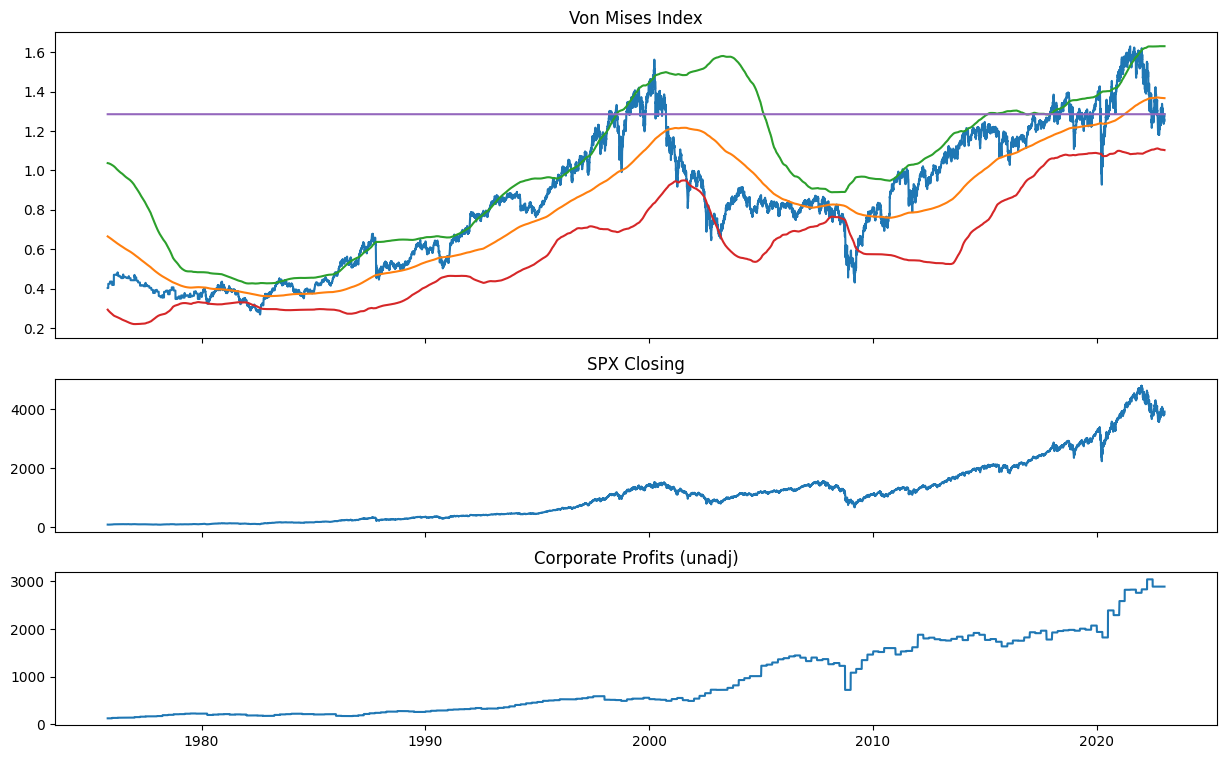

In [118]:
lookback_years = 5
lookback = 252 * lookback_years

### ### ### MERGE INTO SINGLE DATAFRAME ### ### ###
df = pd.concat([net_worth,market_cap,corp_debt_pct,corp_profits,ten_yr],axis=1)
df = df.fillna(method='ffill') #we fill forward because the net worth data only comes in quarterly, therefore we'll retain the last reported figure for each of the daily market cap records
df.dropna(inplace=True)
df['corp_debt'] = df['market_cap'] * (df['corp_debt_pct']/100)
df['ev'] = df['corp_debt'] + df['market_cap']
df['q_ev'] = (df['ev'])/df['net_worth']
df['q_ev_ma'] = df['q_ev'].rolling(lookback).mean()
df['q_mc'] = df['market_cap']/df['net_worth']
df['q_mc_ma'] = df['q_mc'].rolling(lookback).mean()
df['q_mc_sd'] = df['q_mc'].rolling(lookback).std()
df['q_mc_sd2up'] = df['q_mc_ma'] + (2 * df['q_mc_sd'])
df['q_mc_sd2down'] = df['q_mc_ma'] - (2 * df['q_mc_sd'])
df['q_spread'] = df['q_ev'] - df['q_mc']
df['lastprint'] = df['q_mc'][-1]
df = pd.concat([df,spy_df],axis=1)
df.dropna(inplace=True)
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(15,9),gridspec_kw={'height_ratios': [2, 1, 1]})
ax1.plot(df[['q_mc','q_mc_ma','q_mc_sd2up', 'q_mc_sd2down','lastprint']])
ax1.set_title('Von Mises Index')
ax2.plot(df['Close'])
ax2.set_title("SPX Closing")
ax3.plot(df['corp_profits'])
ax3.set_title('Corporate Profits (unadj)')
filename = 'Equities Valuation_'+date.strftime("%Y_%m_%d")+'.png'
plt.savefig(filename)

In [119]:
df['q_mc_zscore'] = stats.zscore(df['q_mc'])
print("Last VMI Print:",np.round(df['q_mc'][-1],decimals=4))
print("Current VMI Print's Percentile:", np.round(stats.norm.cdf(df['q_mc_zscore'][-1]),decimals=4))

Last VMI Print: 1.285
Current VMI Print's Percentile: 0.9058


In [120]:
recent = df.q_mc[-lookback:]
recent = stats.zscore(recent)
recent[-1]
print("Percentile Adjusted for",lookback_years,"Year Lookback:",np.round(stats.norm.cdf(recent[-1]),decimals=4))

Percentile Adjusted for 5 Year Lookback: 0.2681


EARNINGS YIELD LAST PRINT: 7.4218
10YR YIELD LAST PRINT: 3.61
EQ PREMIUM (10YR) LAST PRINT: 3.8118
EQ PREMIUM (BAML BBB Index) LAST PRINT: 1.8818


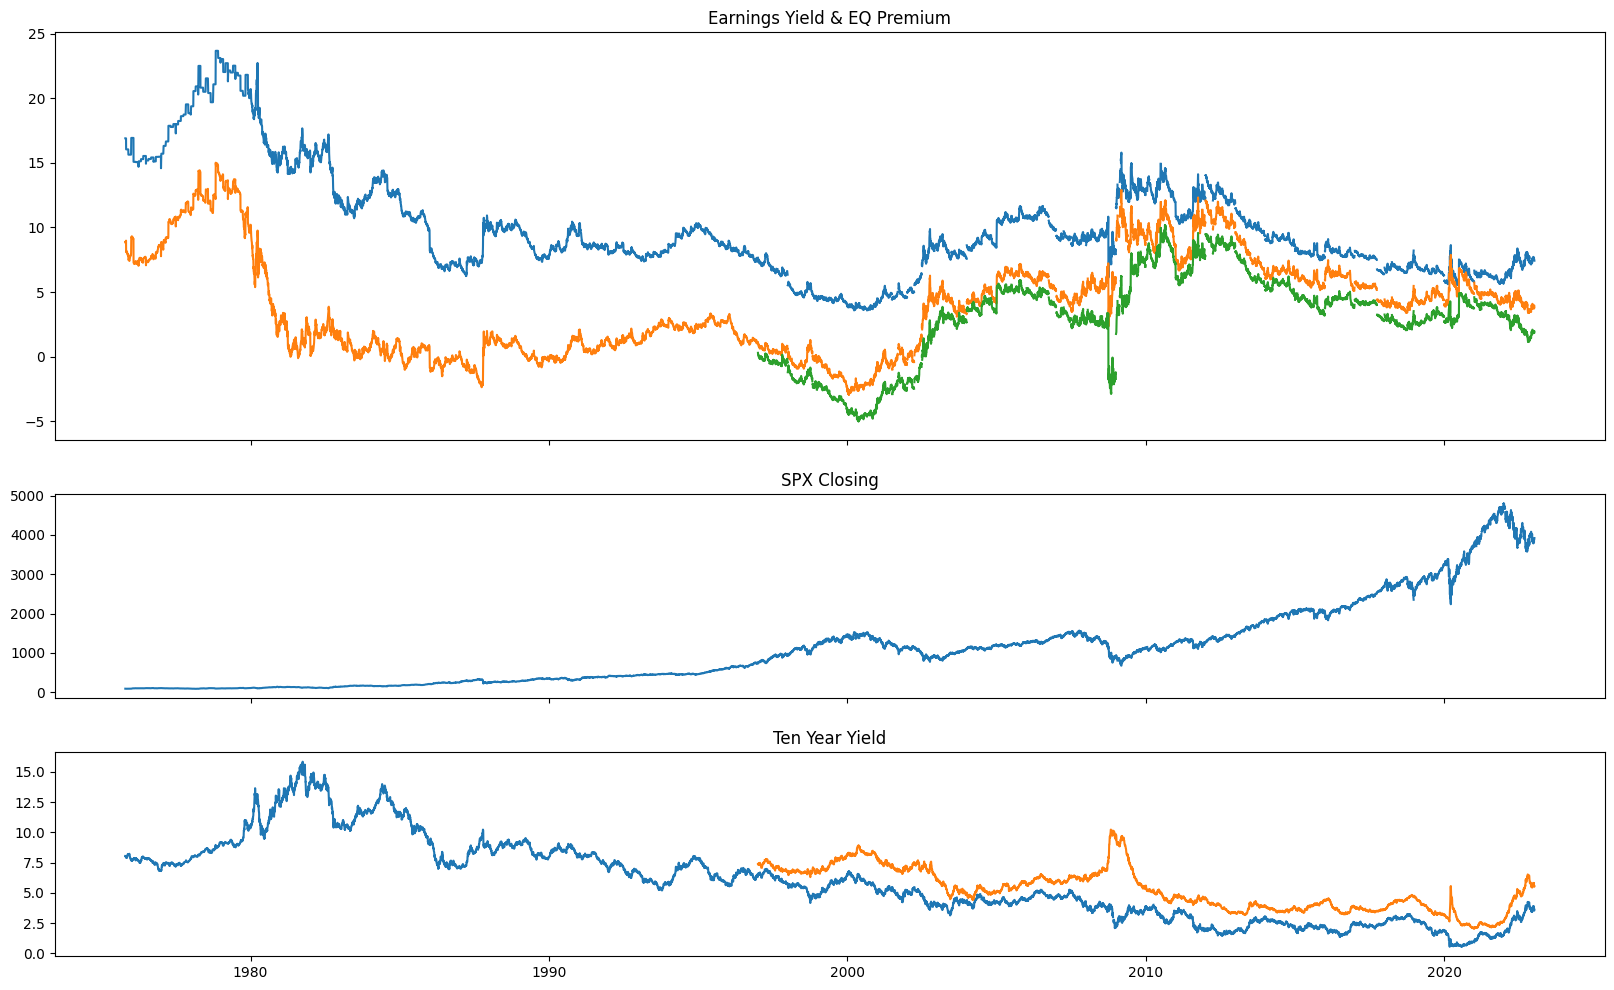

In [121]:
df = pd.concat([df,bbb_corp_index],axis=1)
df['earningsyield'] = df['corp_profits']/df['market_cap']*100
df['eqprem'] = df['earningsyield'] - (df['tenyr'])
df['eqprem_bbb'] = df['earningsyield'] - df['baml_bbb_index']
#df[['earningsyield','eqprem','tenyr']].plot()
#(df['eqprem']/df['tenyr']).plot()
print('EARNINGS YIELD LAST PRINT:', np.round(df['earningsyield'][-1],decimals=4))
print('10YR YIELD LAST PRINT:', np.round((df['tenyr'][-1]),decimals=4))
print('EQ PREMIUM (10YR) LAST PRINT:', np.round(df['eqprem'][-1],decimals=4))
print('EQ PREMIUM (BAML BBB Index) LAST PRINT:', np.round(df['eqprem_bbb'][-1],decimals=4))
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(20,12),gridspec_kw={'height_ratios': [2, 1, 1]})
ax1.plot(df[['earningsyield','eqprem','eqprem_bbb']])
ax1.set_title('Earnings Yield & EQ Premium')
ax2.plot(df['Close'])
ax2.set_title("SPX Closing")
ax3.plot(df[['tenyr','baml_bbb_index']])
ax3.set_title('Ten Year Yield')
filename = 'EQ Premium_'+date.strftime("%Y_%m_%d")+'.png'
plt.savefig(filename)

In [122]:
df = pd.concat([df,CPI,PCE],axis=1)
df = df.fillna(method='ffill')
#df[CPI_rate][-1]

In [125]:
df['CPI_rate'] = ((df['CPI'] -df['CPI'].shift(365)) / df['CPI'])*100
df['PCE_rate'] = ((df['PCE'] -df['PCE'].shift(365)) / df['PCE'])*100
df.tail()

,net_worth,market_cap,corp_debt_pct,corp_profits,tenyr,corp_debt,ev,q_ev,q_ev_ma,q_mc,q_mc_ma,q_mc_sd,q_mc_sd2up,q_mc_sd2down,q_spread,lastprint,Open,High,Low,Close,Volume,q_mc_zscore,baml_bbb_index,earningsyield,eqprem,eqprem_bbb,CPI,PCE,CPI_rate,PCE_rate,real_earnings_yield
2023-01-04,30311.311,38230.65,27.466313,2890.812,3.69,10500.549831,48731.199831,1.607690,1.707935,1.261267,1.366662,0.131544,1.629751,1.103574,0.346423,1.285014,3840.360107,3873.159912,3815.770020,3852.969971,4.414080e+09,1.245265,5.70,7.561504,3.871504,1.861504,298.349,124.747,8.465589,6.655871,7.494945
2023-01-05,30311.311,37782.90,27.466313,2890.812,3.71,10377.569416,48160.469416,1.588861,1.707859,1.246495,1.366593,0.131585,1.629762,1.103424,0.342366,1.285014,3839.739990,3839.739990,3802.419922,3808.100098,3.893450e+09,1.201813,5.72,7.651112,3.941112,1.931112,298.349,124.747,8.465589,6.655871,7.584553
2023-01-06,30311.311,38630.70,27.466313,2890.812,3.55,10610.428814,49241.128814,1.624513,1.707819,1.274465,1.366551,0.131606,1.629762,1.103340,0.350048,1.285014,3823.370117,3906.189941,3809.560059,3895.080078,3.923560e+09,1.284088,5.56,7.483199,3.933199,1.923199,298.349,124.747,8.465589,6.655871,7.416640
2023-01-09,30311.311,38648.30,27.466313,2890.812,3.53,10615.262885,49263.562885,1.625253,1.707781,1.275045,1.366512,0.131625,1.629763,1.103261,0.350208,1.285014,3910.820068,3950.570068,3890.419922,3892.090088,4.311770e+09,1.285796,5.50,7.479791,3.949791,1.979791,298.349,124.747,8.465589,6.655871,7.413232
2023-01-10,30311.311,38950.46,27.466313,2890.812,3.61,10698.255095,49648.715095,1.637960,1.707750,1.285014,1.366478,0.131641,1.629760,1.103196,0.352946,1.285014,3888.570068,3919.830078,3877.290039,3919.250000,3.851030e+09,1.315119,5.54,7.421766,3.811766,1.881766,298.349,124.747,8.465589,6.655871,7.355207


REAL EARNINGS YIELD LAST PRINT: 0.7659
REAL 10YR YIELD LAST PRINT: -3.0459
REAL EQ PREMIUM (10YR) LAST PRINT: 3.8118


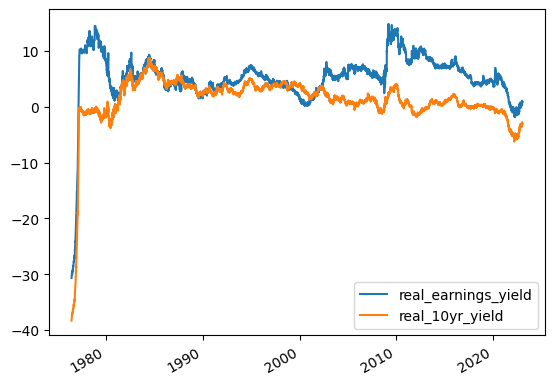

In [132]:
df['real_earnings_yield'] = df['earningsyield'] - df['PCE_rate']
df['real_10yr_yield'] = df['tenyr'] - df['PCE_rate']
df['real_eqprem'] = df['real_earnings_yield'] - df['real_10yr_yield']
df[['real_earnings_yield','real_10yr_yield']].plot()
print('REAL EARNINGS YIELD LAST PRINT:', np.round(df['real_earnings_yield'][-1],decimals=4))
print('REAL 10YR YIELD LAST PRINT:', np.round((df['real_10yr_yield'][-1]),decimals=4))
print('REAL EQ PREMIUM (10YR) LAST PRINT:', abs(np.round(df['real_eqprem'][-1],decimals=4)))

In [ ]:
### ### ### MERGE INTO SINGLE DATAFRAME ### ### ###
df = pd.concat([frb_total_assets, on_rrp, trsy_general_account],axis=1)
df = df.fillna(method='ffill') #we fill forward because the net worth data only comes in quarterly, therefore we'll retain the last reported figure for each of the daily market cap records
df['liq'] = df['frb_ta']-(df['on_rrp']+df['tsy_ga'])
df['liq_ma'] = df['liq'].rolling(lookback).mean()
#df[['liq','frb_ta']].plot()
#df[['on_rrp','tsy_ga']].plot()
df['liq'].plot()
#df

,EFFR,SOFR,spread
2018-04-03,1.69,1.83,-0.14
2018-04-04,1.69,1.74,-0.05
2018-04-05,1.69,1.75,-0.06
2018-04-06,1.69,1.75,-0.06
2018-04-09,1.69,1.75,-0.06
...,...,...,...
2023-01-04,4.33,4.30,0.03
2023-01-05,4.33,4.31,0.02
2023-01-06,4.33,4.31,0.02
2023-01-09,4.33,4.31,0.02


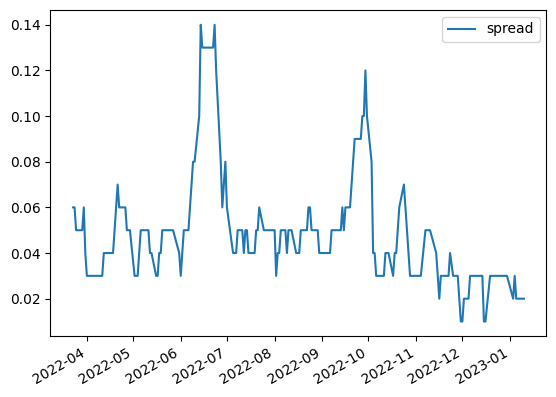

In [ ]:
df = pd.concat([effr, sofr],axis=1)
#df = df.fillna(method='ffill')
df['spread'] = df.EFFR - df.SOFR
df.dropna(inplace=True)
df[-200:][['spread']].plot()
df

In [ ]:
'''### ### ### CHANGE TO OUR STORAGE LOCATION ### ### ###
print('Old Working Directory:',os.getcwd())
os.chdir('/media/Data2/Alpha Hound/Equity Algo/FRED API')
print('New Working Directory:',os.getcwd())'''

"### ### ### CHANGE TO OUR STORAGE LOCATION ### ### ###\nprint('Old Working Directory:',os.getcwd())\nos.chdir('/media/Data2/Alpha Hound/Equity Algo/FRED API')\nprint('New Working Directory:',os.getcwd())"

In [ ]:
'''df.to_csv('Q_Index.csv')'''

"df.to_csv('Q_Index.csv')"

In [ ]:
### ### ### LOG SCRIPT END TIME ### ### ###
end = datetime.now()
print('*****   *****   SCRIPT FINISHED   *****   *****')
print('FINISHED AT: ',end)

*****   *****   SCRIPT FINISHED   *****   *****
FINISHED AT:  2023-01-11 11:16:06.560137


In [ ]:
df = pd.concat([df,spy_df],axis=1)

KeyError: "None of [Index(['q_mc', 'q_mc_ma', 'q_mc_sd2up', 'q_mc_sd2down', 'lastprint'], dtype='object')] are in the [columns]"

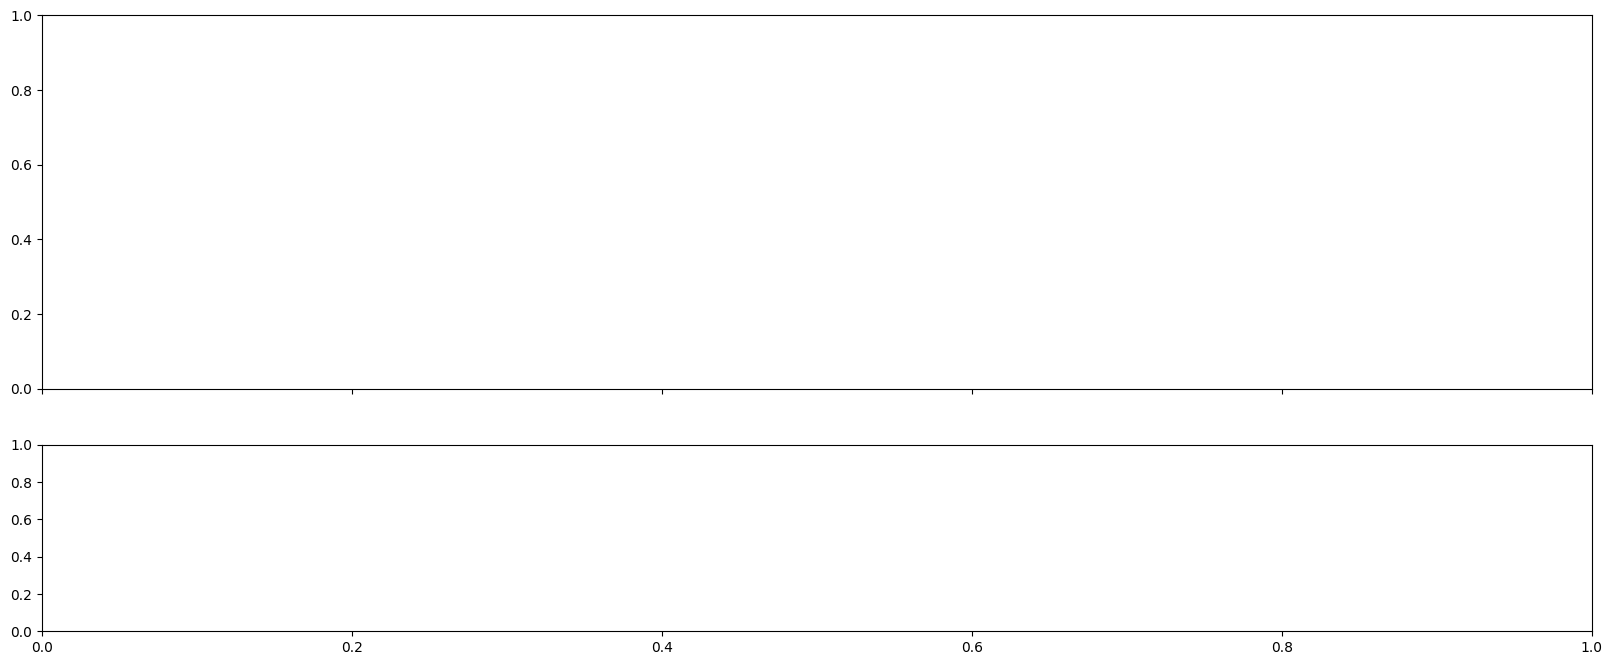

In [ ]:
df.dropna(inplace=True)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(20,8),gridspec_kw={'height_ratios': [2, 1]})
ax1.plot(df[['q_mc','q_mc_ma','q_mc_sd2up', 'q_mc_sd2down','lastprint']])
ax1.set_title('Von Mises Index')
ax2.plot(df['Close'])
ax2.set_title('SPX Closing Price')
plt.savefig('test.png')

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

exam_start = '2004-01-01'
exam_end = '2022-09-29'

plt.subplot(211)
plt.plot(df[exam_start:exam_end].liq)
plt.title(label="liq")


plt.subplot(212)
plt.plot(df[exam_start:exam_end].Close)
plt.title("Closing Price")
plt.legend()
plt.tight_layout

In [ ]:
df